In [1]:
# Imporatamos la triada clásica
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# seaborn
import seaborn as sns
# scipy stats para simular
import scipy.stats as stats
# statsmodels para modelación
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")
import lec6_graphs as gfx
plt.style.use('seaborn') # Gráficos estilo seaborn
# plt.rcParams["figure.figsize"] = (6, 3) # Tamaño gráficos
# plt.rcParams["figure.dpi"] = 200 # resolución gráficos

In [2]:
# ingresamos la base de datos
df = pd.read_csv('wells.csv')
# La base de datos incluye una columna de índice. Eliminemosla para evitar futuros conflictos
df = df.drop("index", axis =1)

In [3]:
print("La base de datos tiene ", df.shape[0], "observaciones y ", df.shape[1], " columnas")
print("Las variables de la base de datos son ", df.columns)

La base de datos tiene  3020 observaciones y  5  columnas
Las variables de la base de datos son  Index(['y', 'dist100', 'arsenic', 'educ4', 'assoc'], dtype='object')


In [4]:
for i in df:
    if len(df[i].value_counts()) > 2:
        print(df[i].describe(), "\n")
    else:
        print(df[i].value_counts('%'), "\n")

1    0.575166
0    0.424834
Name: y, dtype: float64 

count    3020.000000
mean        0.483319
std         0.384787
min         0.003870
25%         0.211172
50%         0.367615
75%         0.640410
max         3.395310
Name: dist100, dtype: float64 

count    3020.000000
mean        1.656930
std         1.107387
min         0.510000
25%         0.820000
50%         1.300000
75%         2.200000
max         9.650000
Name: arsenic, dtype: float64 

count    3020.000000
mean        1.207119
std         1.004329
min         0.000000
25%         0.000000
50%         1.250000
75%         2.000000
max         4.250000
Name: educ4, dtype: float64 

0    0.577152
1    0.422848
Name: assoc, dtype: float64 



In [5]:
df.describe()

,y,dist100,arsenic,educ4,assoc
count,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000
mean,0.575166,0.483319,1.656930,1.207119,0.422848
std,0.494400,0.384787,1.107387,1.004329,0.494093
min,0.000000,0.003870,0.510000,0.000000,0.000000
25%,0.000000,0.211172,0.820000,0.000000,0.000000
50%,1.000000,0.367615,1.300000,1.250000,0.000000
75%,1.000000,0.640410,2.200000,2.000000,1.000000
max,1.000000,3.395310,9.650000,4.250000,1.000000


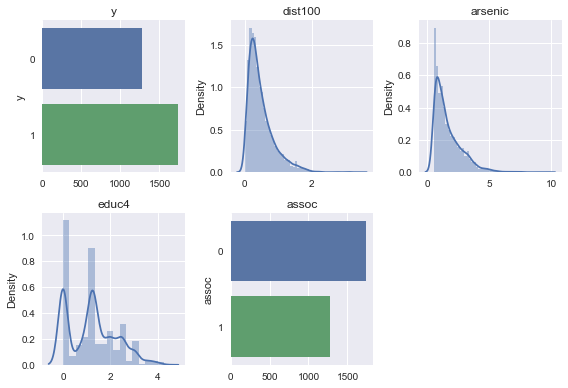

In [6]:
for n, i in enumerate(df):
    plt.subplot(2, 3, n+1)
    if len(df[i].value_counts()) > 2:
        sns.distplot(df[i])
        plt.title(i)
        plt.xlabel("")
    else:
        sns.countplot(y=df[i])
        plt.title(i)
        plt.xlabel("")
    plt.tight_layout()

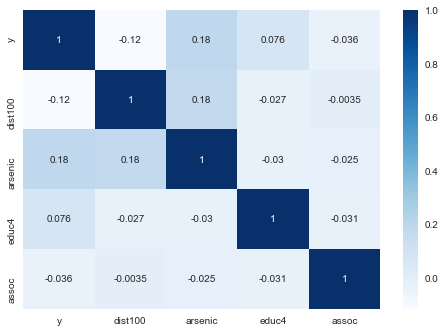

In [7]:
sns.heatmap(df.corr(), cmap='Blues', annot=True);

In [8]:
# ejecutemos nuestro modelo
m1_ols = smf.ols('y ~ dist100', df).fit()

In [9]:
def concise_summary(mod, print_fit=True):
    #guardamos los parámetros asociados a estadísticas de ajuste
    fit = pd.DataFrame({'Statistics': mod.summary2().tables[0][2][2:],
    'Value': mod.summary2().tables[0][3][2:]})
    # guardamos los parámetros estimados por cada regresor.
    estimates = pd.DataFrame(mod.summary2().tables[1].loc[:, 'Coef.': 'Std.Err.'])
    # imprimir fit es opcional
    if print_fit is True:
        print("\nGoodness of Fit statistics\n", fit)
    print("\nPoint Estimates\n\n", estimates)
    # solicitemos las características del modelo

concise_summary(m1_ols)


Goodness of Fit statistics
             Statistics      Value
2                 BIC:  4288.4686
3      Log-Likelihood:    -2136.2
4         F-statistic:      42.57
5  Prob (F-statistic):   7.95e-11
6               Scale:    0.24111

Point Estimates

               Coef.  Std.Err.
Intercept  0.648407  0.014347
dist100   -0.151539  0.023225


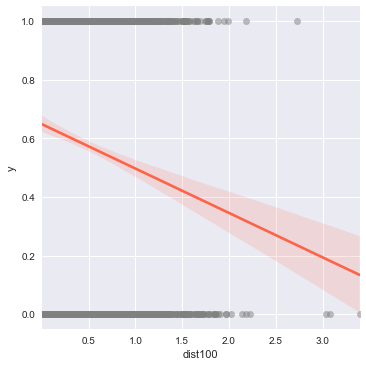

In [10]:
sns.lmplot('dist100','y', df, line_kws={'color':'tomato'}, scatter_kws={'color': 'grey', 'alpha': .5});

In [11]:
m1_logit = smf.logit('y ~ dist100', df).fit()
concise_summary(m1_logit)

Optimization terminated successfully.
         Current function value: 0.674874
         Iterations 4

Goodness of Fit statistics
         Statistics       Value
2             BIC:   4092.2639
3  Log-Likelihood:     -2038.1
4         LL-Null:     -2059.0
5     LLR p-value:  9.7978e-11
6           Scale:      1.0000
7                             

Point Estimates

               Coef.  Std.Err.
Intercept  0.605959  0.060310
dist100   -0.621882  0.097426


In [12]:
# guardamos la media en un objeto
dist100_mean = df['dist100'].mean()
print("La media es de ", round(dist100_mean, 2))

# accedemos a los parámetros con la sintáxis modelo.params['parametro]
estimate_y = m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * dist100_mean)
print("El log odds estimado es de ", round(estimate_y, 2))

La media es de  0.48
El log odds estimado es de  0.31


In [13]:
def invlogit(x):
    return 1 / (1+np.exp(-x))

print("La probabilidad promedio de cambiarse de pozo cuando tenemos una distancia de 48 metros es:", round(invlogit(estimate_y), 2))

La probabilidad promedio de cambiarse de pozo cuando tenemos una distancia de 48 metros es: 0.58


In [14]:
pr_dist_100 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 1))
pr_dist_200 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 2))
pr_dist_300 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 3))
pr_dist_400 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 4))

In [15]:
print("La probabilidad de cambiar de pozo entre 100 y 200 metros: ", round(pr_dist_100 - pr_dist_200, 3))
print("La probabilidad de cambiar de pozo entre 200 y 300 metros: ", round(pr_dist_200 - pr_dist_300, 3))
print("La probabilidad de cambiar de pozo entre 300 y 400 metros: ", round(pr_dist_300 - pr_dist_400, 3))

La probabilidad de cambiar de pozo entre 100 y 200 metros:  0.15
La probabilidad de cambiar de pozo entre 200 y 300 metros:  0.125
La probabilidad de cambiar de pozo entre 300 y 400 metros:  0.089


Una observación tiene igual probabilidad en ambos sucesos cuando x =  0.974


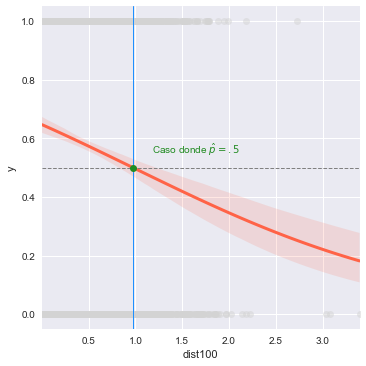

In [16]:
sns.lmplot('dist100', 'y', df, logistic=True, line_kws={'color':'tomato', 'lw': 3}, scatter_kws={'color': 'lightgrey', 'alpha': .5})
decision_boundary = - m1_logit.params['Intercept'] / m1_logit.params['dist100']
plt.axvline(decision_boundary, lw=1, color='dodgerblue')
plt.axhline(.5, linestyle='--', color='grey', lw=1)
plt.text(decision_boundary+.2, .5+.05, r'Caso donde $\hat{p}=.5$', color='forestgreen')
plt.plot(decision_boundary, .5, 'o', color='forestgreen')
print("Una observación tiene igual probabilidad en ambos sucesos cuando x = ",
round(decision_boundary, 3));

In [17]:
print("\nOLS")
concise_summary(m1_ols, print_fit=False)
print("\nLogit")
concise_summary(m1_logit, print_fit=False)


OLS

Point Estimates

               Coef.  Std.Err.
Intercept  0.648407  0.014347
dist100   -0.151539  0.023225

Logit

Point Estimates

               Coef.  Std.Err.
Intercept  0.605959  0.060310
dist100   -0.621882  0.097426


In [18]:
print("La probabilidad de cambiar de pozo entre 100 y 200 metros: ", round(pr_dist_100 - pr_dist_200, 3))

La probabilidad de cambiar de pozo entre 100 y 200 metros:  0.15


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'dist100':'assoc'], df['y'], test_size=.33, random_state=11238)

In [20]:
from sklearn.preprocessing import StandardScaler
# estandarizamos la matriz de entrenamiento
X_train_std = StandardScaler().fit_transform(X_train)
# estandarizamos la matriz de validación
X_test_std = StandardScaler().fit_transform(X_test)
# iniciamos el modelo con la clase LogisticRegression y pasamos los datos en fit.
default_model = LogisticRegression().fit(X_train_std, y_train)

In [21]:
default_model.coef_

array([[-0.33266754,  0.5907759 ,  0.14256382, -0.05195545]])

In [22]:
yhat = default_model.predict(X_test_std)
# solicitemos las primeras 20 observaciones del vector predicho.
yhat[:20]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
      dtype=int64)

In [23]:
from sklearn.metrics import confusion_matrix
m1_confusion = confusion_matrix(y_test, yhat)
m1_confusion

array([[171, 251],
       [117, 458]], dtype=int64)

In [24]:
# comparemos con pd.crosstab
m1_conf_pd = pd.crosstab(y_test, yhat)
m1_conf_pd

col_0,0,1
y,,
0,171,251
1,117,458


In [25]:
from sklearn.metrics import accuracy_score
m1_acc = accuracy_score(y_test, yhat)
m1_acc

0.6308926780341023

In [26]:
from sklearn.metrics import precision_score, recall_score
m1_prec = precision_score(y_test, yhat)
m1_rec = recall_score(y_test, yhat)
print("Precision: ", m1_prec, "\nRecall: ", m1_rec)

Precision:  0.6459802538787024 
Recall:  0.7965217391304348


In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.59      0.41      0.48       422
           1       0.65      0.80      0.71       575

    accuracy                           0.63       997
   macro avg       0.62      0.60      0.60       997
weighted avg       0.62      0.63      0.62       997



In [28]:
from sklearn.metrics import roc_curve
# reestimamos los valores predichos de nuestro modelo para obtener la probabilidad entre 0 y 1.
yhat = default_model.predict_proba(X_test)[:, 1]
# generamos los objetos de roc_cruve
false_positive, true_positive, threshold = roc_curve(y_test, yhat)

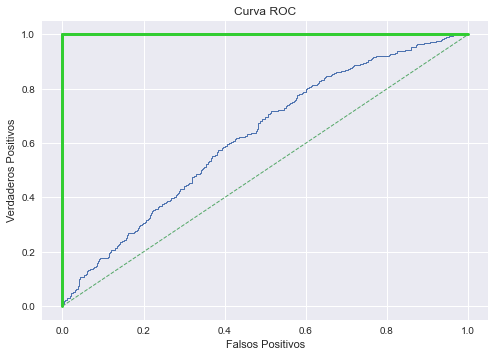

In [29]:
# Plot ROC curve
plt.title('Curva ROC')
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1] , c='limegreen', lw=3)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos');

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, yhat)

0.6266927673603957

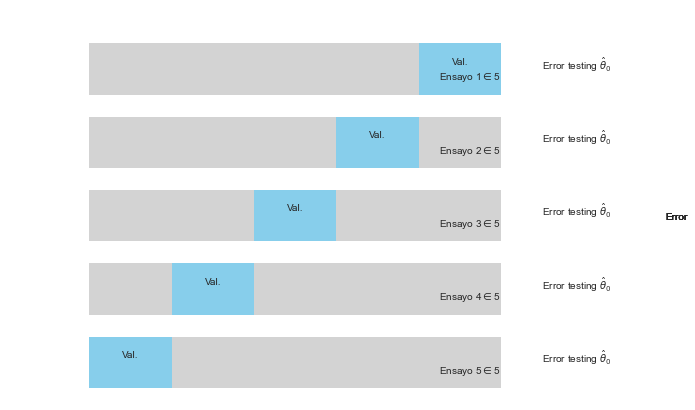

In [31]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.axis('off')
def crossvalidation_schema(cv_folds=5,ax= ax, textprop={}):
    """docstring for crossvalidation_schema"""
    for i in range(cv_folds):
        ax.add_patch(plt.Rectangle((0, i), 5, 0.7, fc='lightgrey'))
        ax.add_patch(plt.Rectangle((5. * i /cv_folds, i), 5. / cv_folds, 0.7, fc='skyblue'))
        ax.text(5. * (i + .5) / cv_folds, i + .45, "Val.", ha='center', va='center', **textprop)
        ax.text(5, i + .15, r'Ensayo {0}$\in${1} '.format(cv_folds - i, cv_folds), ha = 'right', va='bottom', **textprop)
        ax.text(5.5, i + .35, r'Error testing $\hat\theta_{{0}}$'.format(i))
        ax.text(7, 2.3, 'Error')
        ax.set_xlim(-1, 6)
        ax.set_ylim(-0.2, cv_folds + 0.2)

crossvalidation_schema()

In [32]:
from sklearn.model_selection import cross_val_score
m1_cv = cross_val_score(LogisticRegression(), X=df.loc[:,'dist100':'assoc'], y=df.loc[:, 'y'], cv=3, scoring='f1')
m1_cv

array([0.70499244, 0.6888361 , 0.7006079 ])

In [33]:
for i, n in enumerate(m1_cv):
    print("El puntaje F1 para la muestra {0} es {1}".format(i+1, round(n, 2)))

El puntaje F1 para la muestra 1 es 0.7
El puntaje F1 para la muestra 2 es 0.69
El puntaje F1 para la muestra 3 es 0.7


In [34]:
print("El puntaje F1 promedio para el modelo es de: ", round(np.mean(m1_cv), 2))
print("La desviación estandar F1 promedio para el modelo es de: ", round(np.std(m1_cv),2))

El puntaje F1 promedio para el modelo es de:  0.7
La desviación estandar F1 promedio para el modelo es de:  0.01


In [35]:
%%time
from sklearn.model_selection import LeaveOneOut
m1_loocv = cross_val_score(LogisticRegression(), df.loc[:, 'dist100': 'assoc'], df.loc[:,'y'], cv=LeaveOneOut(), scoring='accuracy')

Wall time: 50.8 s


In [36]:
# pidamos las primeras 20 observaciones del array
m1_loocv[:20]

array([1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1.])

In [37]:
print("El puntaje de accuracy promedio para el modelo es de: ", round(np.mean(m1_loocv), 2))
print("La desviación estandar de accuracy promedio para el modelo es de: ", round(np.std(m1_loocv),2))

El puntaje de accuracy promedio para el modelo es de:  0.61
La desviación estandar de accuracy promedio para el modelo es de:  0.49


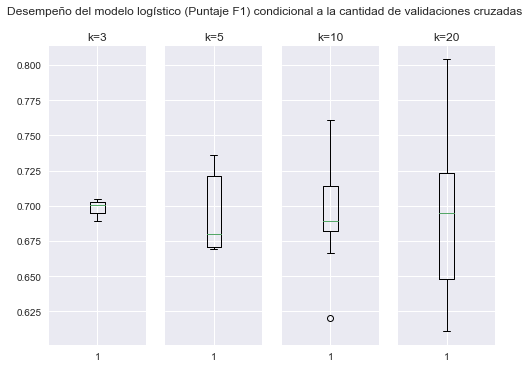

In [38]:
# definimos los criterios en un array
k_fold = [3, 5, 10, 20]
# generamos un gráfico vacío que contenga los gráficos
fig, ax = plt.subplots(1, len(k_fold), sharey='row')
# por cada elemento y su posición en el array
for n, i in enumerate(k_fold):
    # estimar la validación cruzada con el elemento
    tmp = cross_val_score(LogisticRegression(),
    df.loc[:, 'dist100':'assoc'],
    df.loc[:,'y'], cv = i, scoring = 'f1')
    # guardar el gráfico en la posición declarada
    ax[n].boxplot(tmp)
    ax[n].set_title('k={0}'.format(i))
    fig.suptitle('Desempeño del modelo logístico (Puntaje F1) condicional a la cantidad de validaciones cruzadas');

In [39]:
# estandarizamos la matriz de atributos
std_matrix = StandardScaler().fit_transform(df.loc[:, 'dist100':'assoc'])
# Con la clase PolynomialFeature preparamos las otras dos matrices candidatas
from sklearn.preprocessing import PolynomialFeatures
# interacción de 2do orden
df_int_2 = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False).fit_transform(std_matrix)
# interacción de 3er orden
df_int_3 = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False).fit_transform(std_matrix)

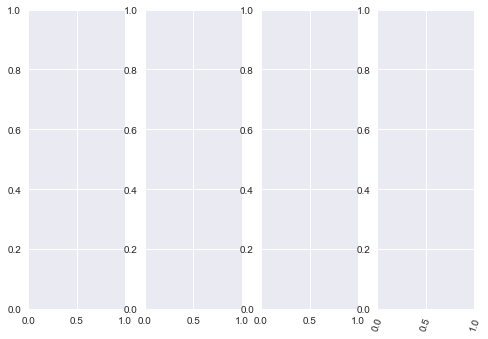

In [40]:
eval_metrics = ['f1', 'precision', 'recall', 'accuracy']
plt.subplots(1, len(eval_metrics))
plt.xticks(rotation=70);

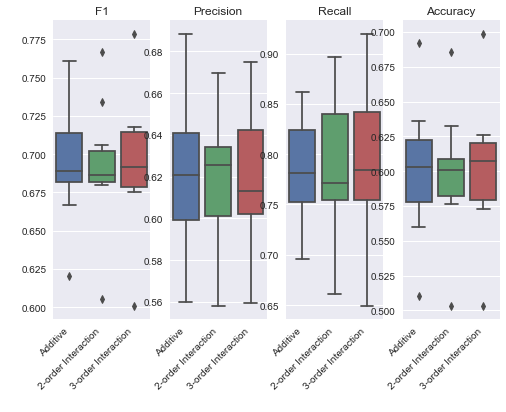

In [41]:
for n, i in enumerate(eval_metrics):
    tmp_1 = cross_val_score(LogisticRegression(), df.loc[:, 'dist100':'assoc'], df.loc[:,'y'], cv = 10, scoring = i)
    tmp_2 = cross_val_score(LogisticRegression(), df_int_2, df.loc[:, 'y'], cv=10, scoring=i)
    tmp_3 = cross_val_score(LogisticRegression(), df_int_3, df.loc[:, 'y'], cv=10, scoring=i)
    tmp = pd.DataFrame({'Additive': tmp_1, '2-order Interaction': tmp_2, '3-order Interaction': tmp_3}).unstack().reset_index()
    tmp.rename(columns={'level_0':'order', 'level_1': 'num', '0': 'score'}, inplace=True)
    plt.subplot(1, 4, n+1)
    sns.boxplot(tmp.iloc[:,0], tmp.iloc[:, 2])
    sns.despine()
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(' ')
    plt.ylabel(' ')
    plt.title(i.capitalize());

Orden: 1, cantidad de atributos estimables: 4. AUC estimada: 0.642
Orden: 5, cantidad de atributos estimables: 125. AUC estimada: 0.663
Orden: 10, cantidad de atributos estimables: 1000. AUC estimada: 0.576
Orden: 15, cantidad de atributos estimables: 3875. AUC estimada: 0.5
Orden: 20, cantidad de atributos estimables: 10625. AUC estimada: 0.5
Orden: 25, cantidad de atributos estimables: 23750. AUC estimada: 0.5


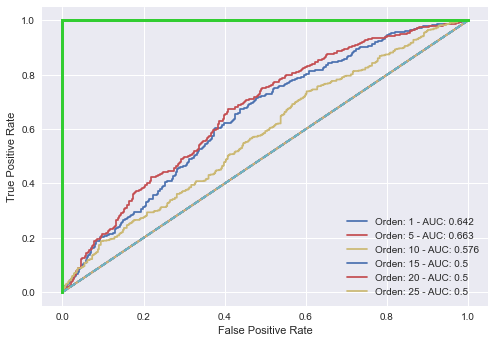

In [42]:
# estandarizamos la matriz de datos
std_matrix = StandardScaler().fit_transform(df.loc[:, 'dist100':'assoc'])
#declaramos los términos
polynomial_order = [1, 5, 10, 15, 20, 25]
# por cada elemento del array
for i in polynomial_order:
    #generamos muestras segmentadas
    X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(std_matrix, df['y'], test_size=.33, random_state=11238)
    # Transformamos la muestra de entrenamiento por i polinomio
    X_train_tmp = PolynomialFeatures(degree=i, interaction_only=False, include_bias=False).fit_transform(X_train_tmp)
    # Transformamos la muestra de evaluación por i polinomio
    X_test_tmp = PolynomialFeatures(degree=i, interaction_only=False, include_bias=False).fit_transform(X_test_tmp)
    # Generamos el modelo predictivo
    tmp_model = LogisticRegression().fit(X_train_tmp, y_train_tmp)
    # Guardamos las predicciones de probabilidad
    tmp_pred = tmp_model.predict_proba(X_test_tmp)[:,1]
    # generamos los arrays con roc_curve
    false_positive, true_positive, threshold = roc_curve(y_test_tmp, tmp_pred)
    # redondeamos los valores del puntaje AUC
    roc_auc_tmp = round(roc_auc_score(y_test_tmp, tmp_pred), 3)
    # graficamos
    plt.plot(false_positive, true_positive, label = 'Orden: {0} - AUC: {1}'.format(i, roc_auc_tmp))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1] , c='limegreen', lw=3)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    # solicitamos información de iteración
    print("Orden: {0}, cantidad de atributos estimables: {1}. AUC estimada: {2}".format(i, X_train_tmp.shape[1], roc_auc_tmp))